In [13]:
# channel indexes
# mask - 0 
# NEW
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
# OLD
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# 1. RF

In [14]:
from sklearn.ensemble import RandomForestClassifier
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import glob
import numpy as np
#from tqdm.notebook import tqdm_notebook as tqdm
#import pandas as pd

**Read to np.array** 

In [15]:
X = []
Y = []
for tile in glob.glob('../../ds/tiles_512_512_27/*/*.tif'):
    if 'no_object' in tile:
        continue
    #print (tile)
    img = io.imread(tile)
    features = np.array(
                np.dstack([
                    img[:,:,17],# old red
                    img[:,:,4], # new red
                    img[:,:,4] - img[:,:,17], # dif
                ]))
    
    X.append(features)
    # join to one class
    Y.append(np.where(img[:,:,0]>0,1,0))

In [16]:
print(f'''Y shape - {np.array(Y).shape}, 
X shape - {np.array(X).shape}''')

Y shape - (1276, 512, 512), 
X shape - (1276, 512, 512, 3)


In [17]:
t_X = np.array(X)
t_X = t_X.reshape(t_X.shape[0]*t_X.shape[1]*t_X.shape[2],t_X.shape[3])


In [18]:
t_X.shape

(334495744, 3)

In [19]:
t_Y = np.array(Y)
t_Y = t_Y.reshape(t_Y.shape[0]*t_Y.shape[1]*t_Y.shape[2])

In [20]:
t_Y.shape

(334495744,)

In [21]:
del X,Y

In [22]:
X_train, X_test, y_train, y_test = train_test_split(t_X, t_Y, test_size=0.2, random_state=42)

In [23]:
del t_X,t_Y

In [24]:
x = StandardScaler().fit_transform(X_train)

clf_rf = RandomForestClassifier(max_samples=10000,
                                verbose=1,
                                n_jobs=3,
                                class_weight="balanced"
                               )
clf_rf.fit(x, y_train)

NameError: name 'StandardScaler' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
preds = clf_rf.predict(StandardScaler().fit_transform(X_test))
print("Accuracy:", accuracy_score(y_test,preds))

In [ ]:
from sklearn.metrics import f1_score
print("F1-score:", f1_score(y_test,preds))

**Read to Df**

In [26]:
X = []
Y = []
for tile in glob.glob('../../ds/tiles_512_512_27//*/*.tif'):
    if 'no_object' in tile:
        continue
    #print (tile)
    img = io.imread(tile)
    features = np.array(
                np.dstack([
                    img[:,:,17],# old red
                    img[:,:,4], # new red
                    img[:,:,4] - img[:,:,17], # dif
                ]))
    
    X.append(features)
    # join to one class
    Y.append(np.where(img[:,:,0]>0,1,0))
X = np.array(X)
Y = np.array(Y)

In [28]:
# X Y from previous operation
import pandas as pd
nFeatures = 3
tileSize = 512
stacked = np.hstack([
    np.array(X).reshape([X.shape[0]*tileSize*tileSize,nFeatures]),
    np.array(Y).reshape([Y.shape[0]*tileSize*tileSize,1])
])
df = pd.DataFrame(data=stacked,columns=["R_old","R_new","R_diff","Y"])

In [29]:
df.head()

,R_old,R_new,R_diff,Y
0,0.051682,0.063721,0.012039,0.0
1,0.052536,0.065842,0.013306,0.0
2,0.058212,0.070160,0.011948,0.0
3,0.074402,0.094452,0.020050,0.0
4,0.084274,0.087265,0.002991,0.0


In [30]:
df_all = pd.concat([
    df[df['Y']==1],
    df[df['Y']==0].head(len(df[df['Y']==1]))
])

In [31]:
len(df_all)

6221394

In [32]:
del df

In [33]:
X = df_all[["R_old","R_new","R_diff"]].to_numpy()
Y = df_all[["Y"]].to_numpy()

In [34]:
X.shape,Y.shape

((6221394, 3), (6221394, 1))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,Y.astype('int'), test_size=0.2, random_state=42)

In [ ]:
X_train.shape

# Optimizing params with GridSearch

In [36]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
            #'criterion': ['entropy', 'gini'],
            'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],   #to zeros 2 - 10,
            'n_estimators': [50, 75, 100, 250,500, 1000] #> 50 - 1000 
}

clf_rf = RandomForestClassifier(
    verbose=1,
    n_jobs=3,
)


grid_searcher = GridSearchCV(clf_rf, parameter_grid, verbose=2)
grid_searcher.fit(X_train, y_train)
clf_best = grid_searcher.best_estimator_
 
print('Best params = ', clf_best.get_params())
#clf_rf.fit(X_train, y_train)


# was observed on 08.10.2020 GridSearch
'''Best params =  {'bootstrap': True, 
                'ccp_alpha': 0.0, 
                'class_weight': None, 
                'criterion': 'gini', 
                'max_depth': 10, 
                'max_features': 'auto', 
                'max_leaf_nodes': None, 
                'max_samples': None, 
                'min_impurity_decrease': 0.0, 
                'min_impurity_split': None, 
                'min_samples_leaf': 1, 
                'min_samples_split': 2, 
                'min_weight_fraction_leaf': 0.0, 
                'n_estimators': 1000, 
                'n_jobs': 3, 
                'oob_score': False, 
                'random_state': None, 
                'verbose': 1, 
                'warm_start': False}
'''

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] max_depth=2, n_estimators=50 ....................................


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   23.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   26.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s remaining:    0.0s


[CV] ..................... max_depth=2, n_estimators=50, total=  28.5s
[CV] max_depth=2, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=2, n_estimators=50, total=  24.1s
[CV] max_depth=2, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=2, n_estimators=50, total=  23.9s
[CV] max_depth=2, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=2, n_estimators=50, total=  24.2s
[CV] max_depth=2, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=2, n_estimators=50, total=  24.0s
[CV] max_depth=2, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   33.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=2, n_estimators=75, total=  35.5s
[CV] max_depth=2, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   33.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.2s finished


[CV] ..................... max_depth=2, n_estimators=75, total=  35.5s
[CV] max_depth=2, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   33.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=2, n_estimators=75, total=  35.6s
[CV] max_depth=2, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   34.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=2, n_estimators=75, total=  36.2s
[CV] max_depth=2, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   34.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=2, n_estimators=75, total=  35.9s
[CV] max_depth=2, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   44.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] .................... max_depth=2, n_estimators=100, total=  46.9s
[CV] max_depth=2, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   45.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV] .................... max_depth=2, n_estimators=100, total=  48.0s
[CV] max_depth=2, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   44.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] .................... max_depth=2, n_estimators=100, total=  46.8s
[CV] max_depth=2, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   44.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV] .................... max_depth=2, n_estimators=100, total=  46.6s
[CV] max_depth=2, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   44.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] .................... max_depth=2, n_estimators=100, total=  46.7s
[CV] max_depth=2, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.1s finished


[CV] .................... max_depth=2, n_estimators=250, total= 1.9min
[CV] max_depth=2, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.0s finished


[CV] .................... max_depth=2, n_estimators=250, total= 1.9min
[CV] max_depth=2, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.0s finished


[CV] .................... max_depth=2, n_estimators=250, total= 1.9min
[CV] max_depth=2, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.0s finished


[CV] .................... max_depth=2, n_estimators=250, total= 1.9min
[CV] max_depth=2, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.1s finished


[CV] .................... max_depth=2, n_estimators=250, total= 1.9min
[CV] max_depth=2, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  3.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.0s finished


[CV] .................... max_depth=2, n_estimators=500, total= 3.8min
[CV] max_depth=2, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  3.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.1s finished


[CV] .................... max_depth=2, n_estimators=500, total= 3.8min
[CV] max_depth=2, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.1s finished


[CV] .................... max_depth=2, n_estimators=500, total= 3.8min
[CV] max_depth=2, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.0s finished


[CV] .................... max_depth=2, n_estimators=500, total= 4.0min
[CV] max_depth=2, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  3.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.0s finished


[CV] .................... max_depth=2, n_estimators=500, total= 3.8min
[CV] max_depth=2, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  7.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_j

[CV] ................... max_depth=2, n_estimators=1000, total= 7.6min
[CV] max_depth=2, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  7.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_j

[CV] ................... max_depth=2, n_estimators=1000, total= 8.0min
[CV] max_depth=2, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  7.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_j

[CV] ................... max_depth=2, n_estimators=1000, total= 7.6min
[CV] max_depth=2, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  6.0min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  7.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.2s
[Parallel(n_j

[CV] ................... max_depth=2, n_estimators=1000, total= 7.8min
[CV] max_depth=2, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  7.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.1s
[Parallel(n_j

[CV] ................... max_depth=2, n_estimators=1000, total= 7.6min
[CV] max_depth=3, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   30.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=3, n_estimators=50, total=  32.5s
[CV] max_depth=3, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   29.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=3, n_estimators=50, total=  31.3s
[CV] max_depth=3, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   31.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=3, n_estimators=50, total=  32.9s
[CV] max_depth=3, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   31.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=3, n_estimators=50, total=  32.6s
[CV] max_depth=3, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   30.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=3, n_estimators=50, total=  31.6s
[CV] max_depth=3, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   44.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=3, n_estimators=75, total=  46.7s
[CV] max_depth=3, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.5s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   46.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=3, n_estimators=75, total=  48.3s
[CV] max_depth=3, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   46.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=3, n_estimators=75, total=  48.8s
[CV] max_depth=3, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.7s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   44.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=3, n_estimators=75, total=  47.0s
[CV] max_depth=3, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.7s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   44.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.3s finished


[CV] ..................... max_depth=3, n_estimators=75, total=  46.2s
[CV] max_depth=3, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   59.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=3, n_estimators=100, total= 1.0min
[CV] max_depth=3, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   58.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=3, n_estimators=100, total= 1.0min
[CV] max_depth=3, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.4s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] .................... max_depth=3, n_estimators=100, total= 1.1min
[CV] max_depth=3, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   28.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=3, n_estimators=100, total= 1.1min
[CV] max_depth=3, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   58.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV] .................... max_depth=3, n_estimators=100, total= 1.0min
[CV] max_depth=3, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.2s finished


[CV] .................... max_depth=3, n_estimators=250, total= 2.5min
[CV] max_depth=3, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.3s finished


[CV] .................... max_depth=3, n_estimators=250, total= 2.5min
[CV] max_depth=3, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.3s finished


[CV] .................... max_depth=3, n_estimators=250, total= 2.5min
[CV] max_depth=3, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.3s finished


[CV] .................... max_depth=3, n_estimators=250, total= 2.6min
[CV] max_depth=3, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.3s finished


[CV] .................... max_depth=3, n_estimators=250, total= 2.7min
[CV] max_depth=3, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  5.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.5s finished


[CV] .................... max_depth=3, n_estimators=500, total= 5.1min
[CV] max_depth=3, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.7s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.6s finished


[CV] .................... max_depth=3, n_estimators=500, total= 5.3min
[CV] max_depth=3, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.5s finished


[CV] .................... max_depth=3, n_estimators=500, total= 5.0min
[CV] max_depth=3, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.6s finished


[CV] .................... max_depth=3, n_estimators=500, total= 5.3min
[CV] max_depth=3, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    8.5s finished


[CV] .................... max_depth=3, n_estimators=500, total= 5.3min
[CV] max_depth=3, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  9.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.5s
[Parallel(n_j

[CV] ................... max_depth=3, n_estimators=1000, total=10.1min
[CV] max_depth=3, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  9.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_j

[CV] ................... max_depth=3, n_estimators=1000, total=10.0min
[CV] max_depth=3, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  9.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_j

[CV] ................... max_depth=3, n_estimators=1000, total=10.0min
[CV] max_depth=3, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  9.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.5s
[Parallel(n_j

[CV] ................... max_depth=3, n_estimators=1000, total=10.1min
[CV] max_depth=3, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:  9.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    7.6s
[Parallel(n_j

[CV] ................... max_depth=3, n_estimators=1000, total=10.0min
[CV] max_depth=4, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   37.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=4, n_estimators=50, total=  39.2s
[CV] max_depth=4, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   36.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=4, n_estimators=50, total=  38.3s
[CV] max_depth=4, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   37.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=4, n_estimators=50, total=  39.4s
[CV] max_depth=4, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   37.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=4, n_estimators=50, total=  38.7s
[CV] max_depth=4, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   36.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.9s finished


[CV] ..................... max_depth=4, n_estimators=50, total=  38.2s
[CV] max_depth=4, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   55.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=4, n_estimators=75, total=  57.7s
[CV] max_depth=4, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   54.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=4, n_estimators=75, total=  56.9s
[CV] max_depth=4, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   54.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.4s finished


[CV] ..................... max_depth=4, n_estimators=75, total=  56.6s
[CV] max_depth=4, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   54.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.4s finished


[CV] ..................... max_depth=4, n_estimators=75, total=  56.2s
[CV] max_depth=4, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:   54.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.4s finished


[CV] ..................... max_depth=4, n_estimators=75, total=  56.5s
[CV] max_depth=4, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=4, n_estimators=100, total= 1.3min
[CV] max_depth=4, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] .................... max_depth=4, n_estimators=100, total= 1.2min
[CV] max_depth=4, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=4, n_estimators=100, total= 1.3min
[CV] max_depth=4, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   34.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV] .................... max_depth=4, n_estimators=100, total= 1.3min
[CV] max_depth=4, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] .................... max_depth=4, n_estimators=100, total= 1.2min
[CV] max_depth=4, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.5s finished


[CV] .................... max_depth=4, n_estimators=250, total= 3.1min
[CV] max_depth=4, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   34.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.6s finished


[CV] .................... max_depth=4, n_estimators=250, total= 3.2min
[CV] max_depth=4, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.6s finished


[CV] .................... max_depth=4, n_estimators=250, total= 3.1min
[CV] max_depth=4, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.6s finished


[CV] .................... max_depth=4, n_estimators=250, total= 3.1min
[CV] max_depth=4, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.6s finished


[CV] .................... max_depth=4, n_estimators=250, total= 3.0min
[CV] max_depth=4, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.1s finished


[CV] .................... max_depth=4, n_estimators=500, total= 6.1min
[CV] max_depth=4, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.2s finished


[CV] .................... max_depth=4, n_estimators=500, total= 6.1min
[CV] max_depth=4, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.0s finished


[CV] .................... max_depth=4, n_estimators=500, total= 6.2min
[CV] max_depth=4, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  6.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.1s finished


[CV] .................... max_depth=4, n_estimators=500, total= 6.5min
[CV] max_depth=4, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   31.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  6.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.0s finished


[CV] .................... max_depth=4, n_estimators=500, total= 6.2min
[CV] max_depth=4, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 12.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.1s
[Parallel(n_j

[CV] ................... max_depth=4, n_estimators=1000, total=12.3min
[CV] max_depth=4, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   34.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 10.0min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 12.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.0s
[Parallel(n_j

[CV] ................... max_depth=4, n_estimators=1000, total=12.9min
[CV] max_depth=4, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   32.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 12.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.0s
[Parallel(n_j

[CV] ................... max_depth=4, n_estimators=1000, total=12.3min
[CV] max_depth=4, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   33.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 11.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.1s
[Parallel(n_j

[CV] ................... max_depth=4, n_estimators=1000, total=12.2min
[CV] max_depth=4, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   34.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 10.0min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 12.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.1s
[Parallel(n_j

[CV] ................... max_depth=4, n_estimators=1000, total=12.9min
[CV] max_depth=5, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   41.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   46.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=5, n_estimators=50, total=  47.9s
[CV] max_depth=5, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   43.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=5, n_estimators=50, total=  45.6s
[CV] max_depth=5, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   44.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=5, n_estimators=50, total=  46.6s
[CV] max_depth=5, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   43.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=5, n_estimators=50, total=  45.4s
[CV] max_depth=5, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   40.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   46.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished


[CV] ..................... max_depth=5, n_estimators=50, total=  48.0s
[CV] max_depth=5, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   37.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=5, n_estimators=75, total= 1.1min
[CV] max_depth=5, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   37.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=5, n_estimators=75, total= 1.1min
[CV] max_depth=5, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=5, n_estimators=75, total= 1.1min
[CV] max_depth=5, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=5, n_estimators=75, total= 1.1min
[CV] max_depth=5, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.5s finished


[CV] ..................... max_depth=5, n_estimators=75, total= 1.1min
[CV] max_depth=5, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] .................... max_depth=5, n_estimators=100, total= 1.5min
[CV] max_depth=5, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   40.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=5, n_estimators=100, total= 1.6min
[CV] max_depth=5, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV] .................... max_depth=5, n_estimators=100, total= 1.5min
[CV] max_depth=5, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   41.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] .................... max_depth=5, n_estimators=100, total= 1.5min
[CV] max_depth=5, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV] .................... max_depth=5, n_estimators=100, total= 1.5min
[CV] max_depth=5, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   40.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.8s finished


[CV] .................... max_depth=5, n_estimators=250, total= 3.9min
[CV] max_depth=5, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.8s finished


[CV] .................... max_depth=5, n_estimators=250, total= 3.7min
[CV] max_depth=5, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.8s finished


[CV] .................... max_depth=5, n_estimators=250, total= 3.7min
[CV] max_depth=5, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.8s finished


[CV] .................... max_depth=5, n_estimators=250, total= 3.7min
[CV] max_depth=5, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    4.8s finished


[CV] .................... max_depth=5, n_estimators=250, total= 3.7min
[CV] max_depth=5, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  7.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.6s finished


[CV] .................... max_depth=5, n_estimators=500, total= 7.3min
[CV] max_depth=5, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  7.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.7s finished


[CV] .................... max_depth=5, n_estimators=500, total= 7.3min
[CV] max_depth=5, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  7.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.5s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.6s finished


[CV] .................... max_depth=5, n_estimators=500, total= 7.2min
[CV] max_depth=5, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  7.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.7s finished


[CV] .................... max_depth=5, n_estimators=500, total= 7.4min
[CV] max_depth=5, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  7.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    9.6s finished


[CV] .................... max_depth=5, n_estimators=500, total= 7.3min
[CV] max_depth=5, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.3min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.4s
[Parallel(n_j

[CV] ................... max_depth=5, n_estimators=1000, total=14.5min
[CV] max_depth=5, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.3min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.6s
[Parallel(n_j

[CV] ................... max_depth=5, n_estimators=1000, total=14.6min
[CV] max_depth=5, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   38.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 14.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.5s
[Parallel(n_j

[CV] ................... max_depth=5, n_estimators=1000, total=15.1min
[CV] max_depth=5, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   41.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.7min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 14.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.5s
[Parallel(n_j

[CV] ................... max_depth=5, n_estimators=1000, total=15.0min
[CV] max_depth=5, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   39.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.3min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    8.5s
[Parallel(n_j

[CV] ................... max_depth=5, n_estimators=1000, total=14.6min
[CV] max_depth=6, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   49.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=6, n_estimators=50, total=  51.4s
[CV] max_depth=6, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   48.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   54.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=6, n_estimators=50, total=  56.0s
[CV] max_depth=6, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   47.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   53.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=6, n_estimators=50, total=  55.7s
[CV] max_depth=6, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   47.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   53.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=6, n_estimators=50, total=  54.8s
[CV] max_depth=6, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   49.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=6, n_estimators=50, total=  51.5s
[CV] max_depth=6, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=6, n_estimators=75, total= 1.3min
[CV] max_depth=6, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.4s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=6, n_estimators=75, total= 1.3min
[CV] max_depth=6, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.7s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=6, n_estimators=75, total= 1.3min
[CV] max_depth=6, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   46.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=6, n_estimators=75, total= 1.3min
[CV] max_depth=6, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.9s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.6s finished


[CV] ..................... max_depth=6, n_estimators=75, total= 1.3min
[CV] max_depth=6, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   45.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=6, n_estimators=100, total= 1.7min
[CV] max_depth=6, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   45.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=6, n_estimators=100, total= 1.7min
[CV] max_depth=6, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   45.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=6, n_estimators=100, total= 1.7min
[CV] max_depth=6, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=6, n_estimators=100, total= 1.7min
[CV] max_depth=6, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV] .................... max_depth=6, n_estimators=100, total= 1.7min
[CV] max_depth=6, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   46.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.2s finished


[CV] .................... max_depth=6, n_estimators=250, total= 4.5min
[CV] max_depth=6, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.2s finished


[CV] .................... max_depth=6, n_estimators=250, total= 4.2min
[CV] max_depth=6, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.2s finished


[CV] .................... max_depth=6, n_estimators=250, total= 4.2min
[CV] max_depth=6, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.2s finished


[CV] .................... max_depth=6, n_estimators=250, total= 4.2min
[CV] max_depth=6, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.1s finished


[CV] .................... max_depth=6, n_estimators=250, total= 4.2min
[CV] max_depth=6, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  8.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.3s finished


[CV] .................... max_depth=6, n_estimators=500, total= 8.4min
[CV] max_depth=6, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  8.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.3s finished


[CV] .................... max_depth=6, n_estimators=500, total= 8.4min
[CV] max_depth=6, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  8.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.3s finished


[CV] .................... max_depth=6, n_estimators=500, total= 8.5min
[CV] max_depth=6, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  8.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.1s finished


[CV] .................... max_depth=6, n_estimators=500, total= 8.4min
[CV] max_depth=6, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  8.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.2s finished


[CV] .................... max_depth=6, n_estimators=500, total= 8.4min
[CV] max_depth=6, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 16.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.0s
[Parallel(n_j

[CV] ................... max_depth=6, n_estimators=1000, total=16.8min
[CV] max_depth=6, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   44.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 16.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.1s
[Parallel(n_j

[CV] ................... max_depth=6, n_estimators=1000, total=16.8min
[CV] max_depth=6, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   45.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 16.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.0s
[Parallel(n_j

[CV] ................... max_depth=6, n_estimators=1000, total=17.2min
[CV] max_depth=6, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 16.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.1s
[Parallel(n_j

[CV] ................... max_depth=6, n_estimators=1000, total=16.8min
[CV] max_depth=6, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   46.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 16.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.1s
[Parallel(n_j

[CV] ................... max_depth=6, n_estimators=1000, total=16.8min
[CV] max_depth=7, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   57.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=7, n_estimators=50, total=  58.9s
[CV] max_depth=7, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   55.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=7, n_estimators=50, total=  57.2s
[CV] max_depth=7, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   57.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=7, n_estimators=50, total=  59.1s
[CV] max_depth=7, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   55.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=7, n_estimators=50, total=  57.7s
[CV] max_depth=7, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   56.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished


[CV] ..................... max_depth=7, n_estimators=50, total=  58.3s
[CV] max_depth=7, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   53.5s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.7s finished


[CV] ..................... max_depth=7, n_estimators=75, total= 1.5min
[CV] max_depth=7, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.7s finished


[CV] ..................... max_depth=7, n_estimators=75, total= 1.4min
[CV] max_depth=7, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   51.7s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.7s finished


[CV] ..................... max_depth=7, n_estimators=75, total= 1.5min
[CV] max_depth=7, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   53.8s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.7s finished


[CV] ..................... max_depth=7, n_estimators=75, total= 1.5min
[CV] max_depth=7, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.7s finished


[CV] ..................... max_depth=7, n_estimators=75, total= 1.5min
[CV] max_depth=7, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   52.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV] .................... max_depth=7, n_estimators=100, total= 2.0min
[CV] max_depth=7, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV] .................... max_depth=7, n_estimators=100, total= 1.9min
[CV] max_depth=7, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV] .................... max_depth=7, n_estimators=100, total= 2.0min
[CV] max_depth=7, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV] .................... max_depth=7, n_estimators=100, total= 1.9min
[CV] max_depth=7, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   48.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV] .................... max_depth=7, n_estimators=100, total= 1.9min
[CV] max_depth=7, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.4s finished


[CV] .................... max_depth=7, n_estimators=250, total= 4.7min
[CV] max_depth=7, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   48.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.4s finished


[CV] .................... max_depth=7, n_estimators=250, total= 4.7min
[CV] max_depth=7, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   53.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.4s finished


[CV] .................... max_depth=7, n_estimators=250, total= 5.0min
[CV] max_depth=7, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.5s finished


[CV] .................... max_depth=7, n_estimators=250, total= 4.7min
[CV] max_depth=7, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.4s finished


[CV] .................... max_depth=7, n_estimators=250, total= 4.8min
[CV] max_depth=7, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   53.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.7min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.8s finished


[CV] .................... max_depth=7, n_estimators=500, total=10.0min
[CV] max_depth=7, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.9s finished


[CV] .................... max_depth=7, n_estimators=500, total= 9.5min
[CV] max_depth=7, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.8s finished


[CV] .................... max_depth=7, n_estimators=500, total= 9.5min
[CV] max_depth=7, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.6min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.8s finished


[CV] .................... max_depth=7, n_estimators=500, total= 9.8min
[CV] max_depth=7, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   52.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  9.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   10.9s finished


[CV] .................... max_depth=7, n_estimators=500, total= 9.7min
[CV] max_depth=7, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   51.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 15.3min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 19.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.6s
[Parallel(n_j

[CV] ................... max_depth=7, n_estimators=1000, total=19.5min
[CV] max_depth=7, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 14.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 18.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_j

[CV] ................... max_depth=7, n_estimators=1000, total=18.9min
[CV] max_depth=7, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 14.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 18.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_j

[CV] ................... max_depth=7, n_estimators=1000, total=18.9min
[CV] max_depth=7, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 14.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 18.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_j

[CV] ................... max_depth=7, n_estimators=1000, total=18.9min
[CV] max_depth=7, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   49.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 14.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 18.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.6s
[Parallel(n_j

[CV] ................... max_depth=7, n_estimators=1000, total=18.9min
[CV] max_depth=8, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=8, n_estimators=50, total= 1.1min
[CV] max_depth=8, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=8, n_estimators=50, total= 1.1min
[CV] max_depth=8, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=8, n_estimators=50, total= 1.1min
[CV] max_depth=8, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=8, n_estimators=50, total= 1.1min
[CV] max_depth=8, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.2s finished


[CV] ..................... max_depth=8, n_estimators=50, total= 1.1min
[CV] max_depth=8, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   56.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=8, n_estimators=75, total= 1.7min
[CV] max_depth=8, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=8, n_estimators=75, total= 1.7min
[CV] max_depth=8, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.0s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=8, n_estimators=75, total= 1.7min
[CV] max_depth=8, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.3s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=8, n_estimators=75, total= 1.6min
[CV] max_depth=8, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=8, n_estimators=75, total= 1.6min
[CV] max_depth=8, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV] .................... max_depth=8, n_estimators=100, total= 2.2min
[CV] max_depth=8, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV] .................... max_depth=8, n_estimators=100, total= 2.1min
[CV] max_depth=8, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV] .................... max_depth=8, n_estimators=100, total= 2.1min
[CV] max_depth=8, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV] .................... max_depth=8, n_estimators=100, total= 2.1min
[CV] max_depth=8, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV] .................... max_depth=8, n_estimators=100, total= 2.2min
[CV] max_depth=8, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.7s finished


[CV] .................... max_depth=8, n_estimators=250, total= 5.2min
[CV] max_depth=8, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.8s finished


[CV] .................... max_depth=8, n_estimators=250, total= 5.2min
[CV] max_depth=8, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.7s finished


[CV] .................... max_depth=8, n_estimators=250, total= 5.2min
[CV] max_depth=8, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.8s finished


[CV] .................... max_depth=8, n_estimators=250, total= 5.5min
[CV] max_depth=8, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    5.8s finished


[CV] .................... max_depth=8, n_estimators=250, total= 5.2min
[CV] max_depth=8, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 10.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.5s finished


[CV] .................... max_depth=8, n_estimators=500, total=10.4min
[CV] max_depth=8, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 10.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.5s finished


[CV] .................... max_depth=8, n_estimators=500, total=10.4min
[CV] max_depth=8, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 10.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.5s finished


[CV] .................... max_depth=8, n_estimators=500, total=10.9min
[CV] max_depth=8, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 10.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.5s finished


[CV] .................... max_depth=8, n_estimators=500, total=10.4min
[CV] max_depth=8, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 10.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   11.5s finished


[CV] .................... max_depth=8, n_estimators=500, total=10.4min
[CV] max_depth=8, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 16.4min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 20.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.1s
[Parallel(n_j

[CV] ................... max_depth=8, n_estimators=1000, total=21.0min
[CV] max_depth=8, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   56.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 16.6min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 21.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_j

[CV] ................... max_depth=8, n_estimators=1000, total=21.4min
[CV] max_depth=8, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 17.0min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 21.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.3s
[Parallel(n_j

[CV] ................... max_depth=8, n_estimators=1000, total=21.5min
[CV] max_depth=8, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   54.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 16.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 20.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.1s
[Parallel(n_j

[CV] ................... max_depth=8, n_estimators=1000, total=21.3min
[CV] max_depth=8, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 16.4min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 20.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_j

[CV] ................... max_depth=8, n_estimators=1000, total=21.0min
[CV] max_depth=9, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] ..................... max_depth=9, n_estimators=50, total= 1.1min
[CV] max_depth=9, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] ..................... max_depth=9, n_estimators=50, total= 1.2min
[CV] max_depth=9, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] ..................... max_depth=9, n_estimators=50, total= 1.2min
[CV] max_depth=9, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] ..................... max_depth=9, n_estimators=50, total= 1.2min
[CV] max_depth=9, n_estimators=50 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] ..................... max_depth=9, n_estimators=50, total= 1.1min
[CV] max_depth=9, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] ..................... max_depth=9, n_estimators=75, total= 1.7min
[CV] max_depth=9, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] ..................... max_depth=9, n_estimators=75, total= 1.7min
[CV] max_depth=9, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.5s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] ..................... max_depth=9, n_estimators=75, total= 1.7min
[CV] max_depth=9, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.5s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] ..................... max_depth=9, n_estimators=75, total= 1.7min
[CV] max_depth=9, n_estimators=75 ....................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.6s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.8s finished


[CV] ..................... max_depth=9, n_estimators=75, total= 1.7min
[CV] max_depth=9, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV] .................... max_depth=9, n_estimators=100, total= 2.3min
[CV] max_depth=9, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV] .................... max_depth=9, n_estimators=100, total= 2.3min
[CV] max_depth=9, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV] .................... max_depth=9, n_estimators=100, total= 2.3min
[CV] max_depth=9, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV] .................... max_depth=9, n_estimators=100, total= 2.3min
[CV] max_depth=9, n_estimators=100 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV] .................... max_depth=9, n_estimators=100, total= 2.3min
[CV] max_depth=9, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.1s finished


[CV] .................... max_depth=9, n_estimators=250, total= 5.6min
[CV] max_depth=9, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.1s finished


[CV] .................... max_depth=9, n_estimators=250, total= 5.6min
[CV] max_depth=9, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.1s finished


[CV] .................... max_depth=9, n_estimators=250, total= 5.6min
[CV] max_depth=9, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.1s finished


[CV] .................... max_depth=9, n_estimators=250, total= 5.8min
[CV] max_depth=9, n_estimators=250 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.1s finished


[CV] .................... max_depth=9, n_estimators=250, total= 5.8min
[CV] max_depth=9, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.9min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.2s finished


[CV] .................... max_depth=9, n_estimators=500, total=11.4min
[CV] max_depth=9, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   60.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.1min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.2s finished


[CV] .................... max_depth=9, n_estimators=500, total=11.6min
[CV] max_depth=9, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.2s finished


[CV] .................... max_depth=9, n_estimators=500, total=11.3min
[CV] max_depth=9, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.2s finished


[CV] .................... max_depth=9, n_estimators=500, total=11.2min
[CV] max_depth=9, n_estimators=500 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.1s finished


[CV] .................... max_depth=9, n_estimators=500, total=11.2min
[CV] max_depth=9, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 17.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 22.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_j

[CV] ................... max_depth=9, n_estimators=1000, total=22.4min
[CV] max_depth=9, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 17.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 22.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_j

[CV] ................... max_depth=9, n_estimators=1000, total=22.4min
[CV] max_depth=9, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 17.5min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 22.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_j

[CV] ................... max_depth=9, n_estimators=1000, total=22.4min
[CV] max_depth=9, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   59.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 17.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 22.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_j

[CV] ................... max_depth=9, n_estimators=1000, total=22.9min
[CV] max_depth=9, n_estimators=1000 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.2min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 18.3min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 23.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.8s
[Parallel(n_j

[CV] ................... max_depth=9, n_estimators=1000, total=23.5min
[CV] max_depth=10, n_estimators=50 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.4s finished


[CV] .................... max_depth=10, n_estimators=50, total= 1.2min
[CV] max_depth=10, n_estimators=50 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] .................... max_depth=10, n_estimators=50, total= 1.2min
[CV] max_depth=10, n_estimators=50 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] .................... max_depth=10, n_estimators=50, total= 1.2min
[CV] max_depth=10, n_estimators=50 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.3s finished


[CV] .................... max_depth=10, n_estimators=50, total= 1.2min
[CV] max_depth=10, n_estimators=50 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.4s finished


[CV] .................... max_depth=10, n_estimators=50, total= 1.2min
[CV] max_depth=10, n_estimators=75 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] .................... max_depth=10, n_estimators=75, total= 1.8min
[CV] max_depth=10, n_estimators=75 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    2.0s finished


[CV] .................... max_depth=10, n_estimators=75, total= 1.8min
[CV] max_depth=10, n_estimators=75 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    2.0s finished


[CV] .................... max_depth=10, n_estimators=75, total= 1.9min
[CV] max_depth=10, n_estimators=75 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    2.0s finished


[CV] .................... max_depth=10, n_estimators=75, total= 1.9min
[CV] max_depth=10, n_estimators=75 ...................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  75 out of  75 | elapsed:    1.9s finished


[CV] .................... max_depth=10, n_estimators=75, total= 1.8min
[CV] max_depth=10, n_estimators=100 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV] ................... max_depth=10, n_estimators=100, total= 2.4min
[CV] max_depth=10, n_estimators=100 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV] ................... max_depth=10, n_estimators=100, total= 2.4min
[CV] max_depth=10, n_estimators=100 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV] ................... max_depth=10, n_estimators=100, total= 2.5min
[CV] max_depth=10, n_estimators=100 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV] ................... max_depth=10, n_estimators=100, total= 2.5min
[CV] max_depth=10, n_estimators=100 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV] ................... max_depth=10, n_estimators=100, total= 2.4min
[CV] max_depth=10, n_estimators=250 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.4s finished


[CV] ................... max_depth=10, n_estimators=250, total= 6.0min
[CV] max_depth=10, n_estimators=250 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  6.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.4s finished


[CV] ................... max_depth=10, n_estimators=250, total= 6.2min
[CV] max_depth=10, n_estimators=250 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  6.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.5s finished


[CV] ................... max_depth=10, n_estimators=250, total= 6.2min
[CV] max_depth=10, n_estimators=250 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.5s finished


[CV] ................... max_depth=10, n_estimators=250, total= 6.0min
[CV] max_depth=10, n_estimators=250 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  6.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    6.4s finished


[CV] ................... max_depth=10, n_estimators=250, total= 6.3min
[CV] max_depth=10, n_estimators=500 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.7min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.8s finished


[CV] ................... max_depth=10, n_estimators=500, total=12.3min
[CV] max_depth=10, n_estimators=500 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 11.0min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.3s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.8s finished


[CV] ................... max_depth=10, n_estimators=500, total=12.5min
[CV] max_depth=10, n_estimators=500 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.9min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.8s finished


[CV] ................... max_depth=10, n_estimators=500, total=12.5min
[CV] max_depth=10, n_estimators=500 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.6min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.8s finished


[CV] ................... max_depth=10, n_estimators=500, total=12.2min
[CV] max_depth=10, n_estimators=500 ..................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.8min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   12.8s finished


[CV] ................... max_depth=10, n_estimators=500, total=12.4min
[CV] max_depth=10, n_estimators=1000 .................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 18.8min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 23.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_j

[CV] .................. max_depth=10, n_estimators=1000, total=24.1min
[CV] max_depth=10, n_estimators=1000 .................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 18.7min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 23.8min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_j

[CV] .................. max_depth=10, n_estimators=1000, total=24.3min
[CV] max_depth=10, n_estimators=1000 .................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 18.9min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 23.9min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.5s
[Parallel(n_j

[CV] .................. max_depth=10, n_estimators=1000, total=24.4min
[CV] max_depth=10, n_estimators=1000 .................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 18.6min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 23.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_j

[CV] .................. max_depth=10, n_estimators=1000, total=24.1min
[CV] max_depth=10, n_estimators=1000 .................................


/home/andrew.tarasov1993.gmail.com/anaconda3/envs/tf_last/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.7min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 19.2min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 24.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   11.4s
[Parallel(n_j

[CV] .................. max_depth=10, n_estimators=1000, total=24.4min


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 14.7min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 26.2min


Best params =  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': 3, 'oob_score': False, 'random_state': None, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 33.1min finished


# Optimizing params with skopt

In [5]:
from functools import partial
from skopt import space, gp_minimize

In [45]:
y_train.shape

(4977115, 1)

In [72]:
clf_rf = RandomForestClassifier(
    criterion="gini",
    verbose=0,
    n_jobs=3,
    max_depth=10,
    n_estimators=1000
)
clf_rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=3)

In [73]:
from sklearn.metrics import f1_score
preds = clf_rf.predict(X_test)
print("F1-score:", f1_score(y_test,preds))

F1-score: 0.9658195888120142


**Show test predict**

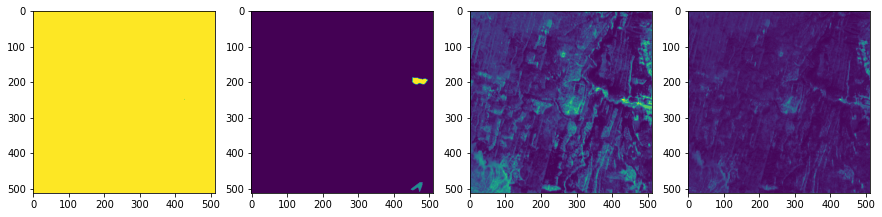

In [75]:
def predictTestImg(imgPath):

    #test_img = io.imread('./ds/tiles/T41VLE_pair_3.tif/T41VLE_pair_3.tif_1073_2924_with_object.tif')
    test_img = io.imread(imgPath)/65536

    test_array = np.dstack([
                    test_img[:,:,17],# old red
                    test_img[:,:,4], # new red
                    test_img[:,:,4] - test_img[:,:,17], # dif
                ])

    test_predict = clf_rf.predict(test_array.reshape([512*512,3]))


    test_predict = test_predict.reshape([512,512,1])

    fig,axes = plt.subplots(ncols=4,figsize=(15,15))
    axes[0].imshow(test_predict[:,:,0])
    axes[1].imshow(test_img[:,:,0])
    axes[2].imshow(test_img[:,:,4])
    axes[3].imshow(test_img[:,:,17])
    return test_predict,img
    
    
predictResult,img = predictTestImg('../../ds/tiles_512_512_27/T41VLE_pair_3.tif/T41VLE_pair_3.tif_1006_8184_with_object.tif')

In [76]:
print (predictResult.sum(),predictResult.shape[0]*predictResult.shape[1])

262143 262144


In [69]:
def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    #x = (intersection + 1e-15) / (union + 1e-15)
    x = (intersection + 1) / (union + 1)
    x = x.astype(np.float32)
    return x

In [70]:
f(img[:,:,0],predictResult[:,:,0])

0.0010566711

# 2. Logistic regression

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [51]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(X_train)

skf = StratifiedKFold(n_splits=10)

scores = []

for train_index, test_index in skf.split(x, y_train):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y_train[train_index], y_train[test_index]
    est = LogisticRegression(n_jobs=5, class_weight='balanced', verbose=1)
    est.fit(x_train, y_train)
    pred = est.predict(x_test)
    score = f1_score(y_test, pred)
    scores.append(score)
    print(score)

ValueError: Found input variables with inconsistent numbers of samples: [267596595, 240836935]

# Save models

In [14]:
import pickle

In [18]:
with open('test','wb') as f:
    pickle.dump(clf_rf,f)

# Tests

In [11]:
np.sum(t_Y)/t_Y.shape[0]

0.00929966092483377

In [96]:
t = np.ravel(X[0])

In [97]:
t_back = t.reshape([512,512,3])

In [93]:
x_train = [
    [1, 2], [5, 6],
    [3, 4], [7, 8],
    [-1, 2], [-5, 6],
    [-3, 4], [-7, 8], [0, 0]
]
np.array(x_train).shape

(9, 2)

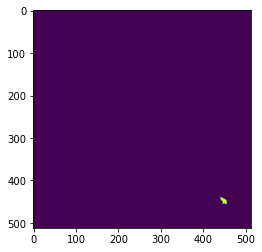

In [89]:
plt.imshow(Y[2])

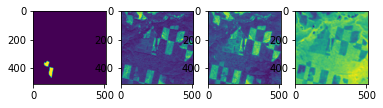

In [29]:
fig,axes = plt.subplots(ncols=4)
axes[0].imshow(img[:,:,0])
axes[1].imshow(img[:,:,25])
axes[2].imshow(img[:,:,12])
axes[3].imshow(img[:,:,24] - img[:,:,10])